Installing required resources
----------------

In [44]:
# Using pip3 to install for Python 3.x; remove the quiet flag (-q) if you want to see the output

# Standard downloads
!pip3 -q install numpy scipy pandas matplotlib pymatbridge seaborn gitpython --user

# The spinkyDemo package, which provide a set of utilitary functions useful to avoid clutering 
# this example with a lot of code.
!pip3 -q install git+https://github.com/christian-oreilly/spinkyDemo.git --user --upgrade

# Cloning the SPINKY Matlab Git repository
import os, scipy
from git import Repo
git_url = "https://github.com/TarekLaj/SPINKY.git"
spinkyPath = os.path.join(os.getcwd(), "SPINKY")
if not os.path.isdir(spinkyPath):
    Repo.clone_from(git_url, spinkyPath)
else:
    Repo(spinkyPath).remotes.origin.pull()        
        
        
# Downloading an example of EEG + scoring from the DREAMS database        
# for the spindle example...
if not os.path.isfile("excerpt5.txt"):
    !wget "http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseSpindles/excerpt5.txt"
    !wget "http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseSpindles/Visual_scoring1_excerpt5.txt"   
    !wget "http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseSpindles/Hypnogram_excerpt5.txt"

# for the K-complex example
if not os.path.isfile("excerpt2.txt"):
    !wget "http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseKcomplexes/excerpt2.txt"
    !wget "http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseKcomplexes/Visual_scoring1_excerpt2.txt"
    !wget "http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseKcomplexes/Hypnogram_excerpt2.txt"

--2016-12-04 13:58:12--  http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseSpindles/excerpt5.txt
Resolving www.tcts.fpms.ac.be (www.tcts.fpms.ac.be)... 193.190.210.20
Connecting to www.tcts.fpms.ac.be (www.tcts.fpms.ac.be)|193.190.210.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4320009 (4.1M) [text/plain]
Saving to: 'excerpt5.txt.2'

100%[======================================>] 4,320,009   20.7MB/s   in 0.2s   

2016-12-04 13:58:12 (20.7 MB/s) - 'excerpt5.txt.2' saved [4320009/4320009]

--2016-12-04 13:58:12--  http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseSpindles/Visual_scoring1_excerpt5.txt
Resolving www.tcts.fpms.ac.be (www.tcts.fpms.ac.be)... 193.190.210.20
Connecting to www.tcts.fpms.ac.be (www.tcts.fpms.ac.be)|193.190.210.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1311 (1.3K) [text/plain]
Saving to: 'Visual_scoring1_excerpt5.txt.2'

100%[======================================>] 1,311       --.-K/s   in

Importing required functions and packages
--------------

In [2]:
# Standard imports
import numpy as np
from scipy.io import savemat 
import sys
import os
from glob import glob
import pandas as pd
import seaborn as sb
import matplotlib.pylab as plt

# Imports from spinkyDemo
from spinkyDemo import training_process, test_process, readDetectorOutput
from spinkyDemo import sensitivity, specificity, PPV, MCC, cohenk, F1

/home/oreilly/.local/lib/python3.4/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


Defining some constants...
---------------------------

In [40]:
# Constants to change by the user depending on the type of detection and the data source wanted...

mode         = 'spindles'      # 'kcomplex' to detect K-complexes
                               # 'spindles' to detect spindles     
data_source  = 'SPINKY'        # DREAMS to use the DREAMS database
                               # SPINKY to use the sample provided with the SPINKY toolbox

In [53]:
#Defining appropriate contants that depends on the type of detection and the data source...

pageDuration = 30.0 # Page length, in seconds;
if data_source == 'DREAMS':
    nbTrainPage  = int(5*60/pageDuration)   # Number of pages to use for the training. Using 5 min of training.
    
    if mode == "spindles":
        eegFileName     = "excerpt5.txt"
        scoringFileName = "Visual_scoring1_excerpt5.txt"
        hypnoFileName   = "Hypnogram_excerpt5.txt"
        subjectName     = "excerpt5"
        fs              = 200.0       # Sampling frequency, in Hz
        from spinkyDemo import sp_thresholds_ranges as thresholds_ranges
        outputFileName  = "score_auto_spindles_" + subjectName + ".txt"

    elif mode == "kcomplex":
        eegFileName     = "excerpt2.txt"
        scoringFileName = "Visual_scoring1_excerpt2.txt"
        hypnoFileName   = "Hypnogram_excerpt2.txt"
        subjectName     = "excerpt2"
        fs              = 200.0       # Sampling frequency, in Hz   
        from spinkyDemo import kp_thresholds_ranges as thresholds_ranges 
        outputFileName  = "score_auto_Kcomplex_" + subjectName + ".txt"

    else:
        raise ValueError("The 'mode' must be equal to 'spindles' or 'kcomplex'. Current value: '%s'" % mode)
        
elif data_source == 'SPINKY':

    if mode == "spindles":
        eegFileName_train     = os.path.join(spinkyPath, "training_data.mat")
        eegFileName_test      = os.path.join(spinkyPath, "test_data.mat")
        scoringFileName_test  = os.path.join(spinkyPath, "Spindles_visual_score_test_data.txt")
        scoringFileName_train = os.path.join(spinkyPath, "Spindles_visual_score_training_data.txt")
        
        subjectName     = "spinkySubject"
        fs              = 1000.0           # Sampling frequency, in Hz

        from spinkyDemo import sp_thresholds_ranges as thresholds_ranges 
        outputFileName  = "score_auto_spindles_" + subjectName + ".txt"

    elif mode == "kcomplex":
        raise ValueError("No K-complex detection is available for SPINKY's sample. To use this " +
                         "data source, 'mode' must be equal to 'spindles'.")
        
    else:
        raise ValueError("When using the SPINKY sample, the 'mode' must be equal to 'spindles'." +
                         " Current value: '%s'" % mode)
        
else:
    ValueError("The 'data_source' must be equal to 'DREAMS' or 'SPINKY'. Current value: '%s'" % data_source)

samplePerPage   = int(pageDuration*fs)

Preparing the training and testing signals
---------------------

In [85]:
if data_source == 'DREAMS':
    eegSig          = pd.read_csv(eegFileName, names=["signal"], skiprows=[0])["signal"].values
    stages          = pd.read_csv(hypnoFileName, names=["stage"], skiprows=[0])["stage"].values[::6] #Hyponogram scored every 5s for DREAMS
    scoring         = pd.read_csv(scoringFileName, sep="\t", names=["start", "duration"], skiprows=[0])
    scoringStart    = scoring["start"].values
    scoringDuration = scoring["duration"].values
    numberOfPages   = int(len(eegSig)/samplePerPage)

    # Getting signals based on two mutually exclusive set of pages for training and testing
    np.random.seed(42)
    pageIds      = [i for i in range(numberOfPages) if int(stages[i]) == 2]
    pageIds      = [i for i in range(numberOfPages) if int(stages[i]) == 2 and i*pageDuration < 1000.0]


    trainPageIds = np.random.choice(pageIds, nbTrainPage, replace=False)
    trainSig     = eegSig[np.concatenate([np.arange(samplePerPage)+i*samplePerPage 
                                          for i in pageIds if i in trainPageIds])]
    testSig      = eegSig[np.concatenate([np.arange(samplePerPage)+i*samplePerPage 
                                          for i in pageIds if not i in trainPageIds])]

    # Calculating the number of spindles scored in the training pages
    def eventInPage(eventStart, pageId):
        pageStart = pageId*pageDuration
        pageEnd   = pageStart + pageDuration    
        return (eventStart >= pageStart)*(eventStart < pageEnd)

    nbEvents = [sum(eventInPage(scoringStart, pageId)) for pageId in trainPageIds]   
    
    
elif data_source == 'SPINKY':
    trainSig             = scipy.io.loadmat(eegFileName_train)["mat"][0]
    testSig              = scipy.io.loadmat(eegFileName_test)["mat"][0]

    numberOfPages_train  = int(len(trainSig)/samplePerPage)
    numberOfPages_test   = int(len(testSig)/samplePerPage)

    scoring_test         = pd.read_csv(scoringFileName_test, sep=" ", names=["pageNo", "start", "end"], 
                                       index_col=False, skipinitialspace=True)
    scoringStart_test    = scoring_test["start"].values
    scoringDuration_test = scoring_test["end"].values - scoringStart_test 


    scoring_train        = pd.read_csv(scoringFileName_train, sep=" ", names=["pageNo", "start", "end"], 
                                       index_col=False, skipinitialspace=True)
    scoringStart_train   = scoring_train["start"].values
    scoringDuration_train= scoring_train["end"].values - scoringStart_train  

    nbEvents = [sum(scoring_train["pageNo"] == indPage+1) for indPage in range(numberOfPages_train)]

    
else:
    ValueError("The 'data_source' must be equal to 'DREAMS' or 'SPINKY'. Current value: '%s'" % data_source)


Starting Matlab and adding necessary paths to Matlab environement variable
--------

In [80]:
from pymatbridge import Matlab
mlab = Matlab(maxtime=60) #Matlab(matlab='C:/Program Files/MATLAB/R2015a/bin/matlab.exe')
mlab.start()

matlabCode = \
"rootPath = '" + spinkyPath + "/'; \n" + """
addpath(rootPath) 
addpath([rootPath 'functions'])
addpath([rootPath 'functions/tqwt_matlab_toolbox/tqwt_matlab_toolbox'])
"""
result = mlab.run_code(matlabCode)

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-27ea6d3e-4169-47bf-b8b5-b4477b64bfb3
Send 'exit' command to kill the server
..........MATLAB started and connected!


Example of threshold estimation (for spindles detection)
---------------

In [81]:
threshold = thresholds_ranges(mlab, trainSig, samplePerPage, fs)[0]

In [82]:
threshold = training_process(mlab, trainSig, fs, samplePerPage, mode, threshold, nbEvents)
print("Threshold:", threshold) 

Threshold: 151


Example of spindle detection
---------------

In [84]:
# This call create a file named score_auto_YYYYYY_XXXXXX.txt where XXXXXX is the value of subjectName
# and YYYYYY takes eithers spindles or Kcomplex depending on the value of mode.
if os.path.isfile(outputFileName):
    os.remove(outputFileName)
test_process(mlab, testSig, fs, samplePerPage, subjectName, threshold, mode)

array([[ 5.,  5.,  1.,  3.,  2.,  3.,  1.,  1.,  3.,  0.]])

Closing Matlab
-----------------------

In [86]:
mlab.quit()

{'content': {'stdout': 'Too many output arguments.'},
 'result': '',
 'success': False}

Example of performance assessment
---------------

In [35]:
def makeIndexSignal(events, epoch_length, fs):    
    index = np.zeros((int(epoch_length*fs), 1))
    for s, e in events:
        index[int(np.round(s*fs)):int(np.round(e*fs))] = 1
    return index
    
    
def compute2classComp(indGold, indTest):    
    
    TP = np.logical_and(indGold, indTest)
    TN = np.logical_and(np.logical_not(indGold), np.logical_not(indTest)) 
    FP = np.logical_and(np.logical_not(indGold), indTest)
    FN = np.logical_and(indGold, np.logical_not(indTest))

    return TP, TN, FP, FN


def prinResults(TP, TN, FP, FN):
    res = ( sensitivity(TP, TN, FP, FN), 
            specificity(TP, TN, FP, FN),
            PPV(TP, TN, FP, FN), 
            MCC(TP, TN, FP, FN),
            cohenk(TP, TN, FP, FN), 
            F1(TP, TN, FP, FN))
    print(("sensitivity=%f, specificity=%f, PPV=%f,  MCC=%f, CohenK=%f, F1=%f" % res))     
    return res

detectedEvents = readDetectorOutput(outputFileName, mode)

TP = []
TN = [] 
FP = []
FN = []

indGoldAll = []
indTestAll = []

if data_source == 'SPINKY':
    pageIds_test = range(numberOfPages_test)
elif data_source == 'DREAMS':
    pageIds_test = [pageId for pageId in pageIds if not pageId in trainPageIds]
    
detectedPageNo = 0
for pageId in pageIds_test:

    detectedPageNo += 1

    pageStart = pageId*pageDuration
    pageEnd   = pageStart + pageDuration  

    eventPage = []
    if mode == "spindles":
        eventPage = [(eStart - pageStart, eStart + eDuration - pageStart) 
                        for eStart, eDuration in zip(scoringStart, scoringDuration) 
                                       if eventInPage(eStart, pageId)]

        detectEventPage = [(event["start"], event["end"]) for index, event 
                             in detectedEvents[detectedEvents["page"] == detectedPageNo].iterrows()]            

    elif mode == "kcomplex":
        for eStart, eDuration in zip(scoringStart, scoringDuration):
            if eventInPage(eStart, pageId):
                sig = eegSig[np.arange(int(eStart*fs), int((eStart+eDuration)*fs))]                
                pic = eStart - pageStart + float(np.argmin(sig))/fs
                eventPage.append((pic-0.1, pic+1.3))    

        detectEventPage = [(event["time"]-0.1, event["time"]+1.3) for index, event 
                             in detectedEvents[detectedEvents["page"] == detectedPageNo].iterrows()]                

    indGold = makeIndexSignal(eventPage, pageDuration, fs)
    indTest = makeIndexSignal(detectEventPage, pageDuration, fs)

    indGoldAll.extend(indGold)
    indTestAll.extend(indTest)

    TPtmp, TNtmp, FPtmp, FNtmp = compute2classComp(indGold, indTest)
    TP.extend(TPtmp)
    TN.extend(TNtmp)
    FP.extend(FPtmp)
    FN.extend(FNtmp)    


    
else:
    ValueError("The 'data_source' must be equal to 'DREAMS' or 'SPINKY'. Current value: '%s'" % data_source)



print("")
prinResults(np.sum(TP, dtype=np.int64), 
            np.sum(TN, dtype=np.int64), 
            np.sum(FP, dtype=np.int64), 
            np.sum(FN, dtype=np.int64))
print("")


sensitivity=0.539815, specificity=0.963501, PPV=0.458349,  MCC=0.466161, CohenK=0.464406, F1=0.495758



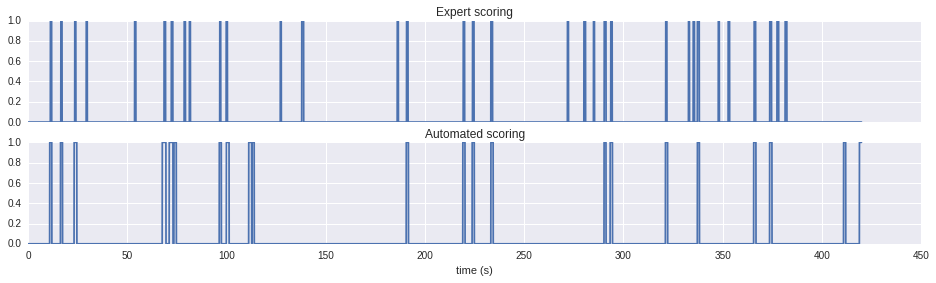

In [33]:
%matplotlib inline

fig, axes = plt.subplots(2, 1, figsize=(16, 4), sharex=True)
axes[0].plot(np.arange(len(indGoldAll))/fs, indGoldAll)
axes[0].set_title("Expert scoring")

axes[1].plot(np.arange(len(indTestAll))/fs, indTestAll)
axes[1].set_title("Automated scoring")
axes[1].set_xlabel("time (s)")
